# Генерация графов

Поскольку графы состоят из несвязанных клик, то просто возьмем 4 крупнейших и свяжем их мостами.

In [1]:
import pandas as pd

In [2]:
import networkx as nx

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tr=pd.read_excel('globalterrorismdb_0718dist.xlsx')

In [5]:
r=tr[(tr["iyear"]==2001) | (tr["iyear"]==2011)]

In [6]:
def to_list(l):
    res=[]
    for _, i in l.iterrows():
        adj=i['related'].split(',')
        for j in adj:
            res.append((i['eventid'], int(j)))
    return res

In [7]:
def rename_nodes(g):
    nn=dict()
    c=0
    for i in g.nodes:
        if i not in nn:
            nn[i]=c
            c+=1
    return nx.relabel_nodes(g, nn)

In [8]:
from random import choice as rc
def generate_connected_subgraph(g, l):
    k=sorted(list(nx.connected_component_subgraphs(g)), key=len)[-4:]
    res=[]
    rg=len(k)
    for i in range(len(k)-1):
        if l:
            rg=i+2
        for j in range(i+1,rg):
            res.append([rc(list(k[i].nodes)), rc(list(k[j].nodes))])
    G=nx.Graph()
    for i in k:
        G=nx.compose(G,i)
    G.add_edges_from(res)
    return G

In [9]:
yl=r["iyear"].unique()
t=r[["iyear","eventid", "related"]]
graphs=[]
for i in range(len(yl)):
    g=nx.Graph()
    l=t[t["iyear"]==yl[i]]
    g.add_edges_from(to_list(l[["eventid", "related"]].dropna()))
    g.remove_edges_from(g.selfloop_edges())
    graphs.append(generate_connected_subgraph(g, i))

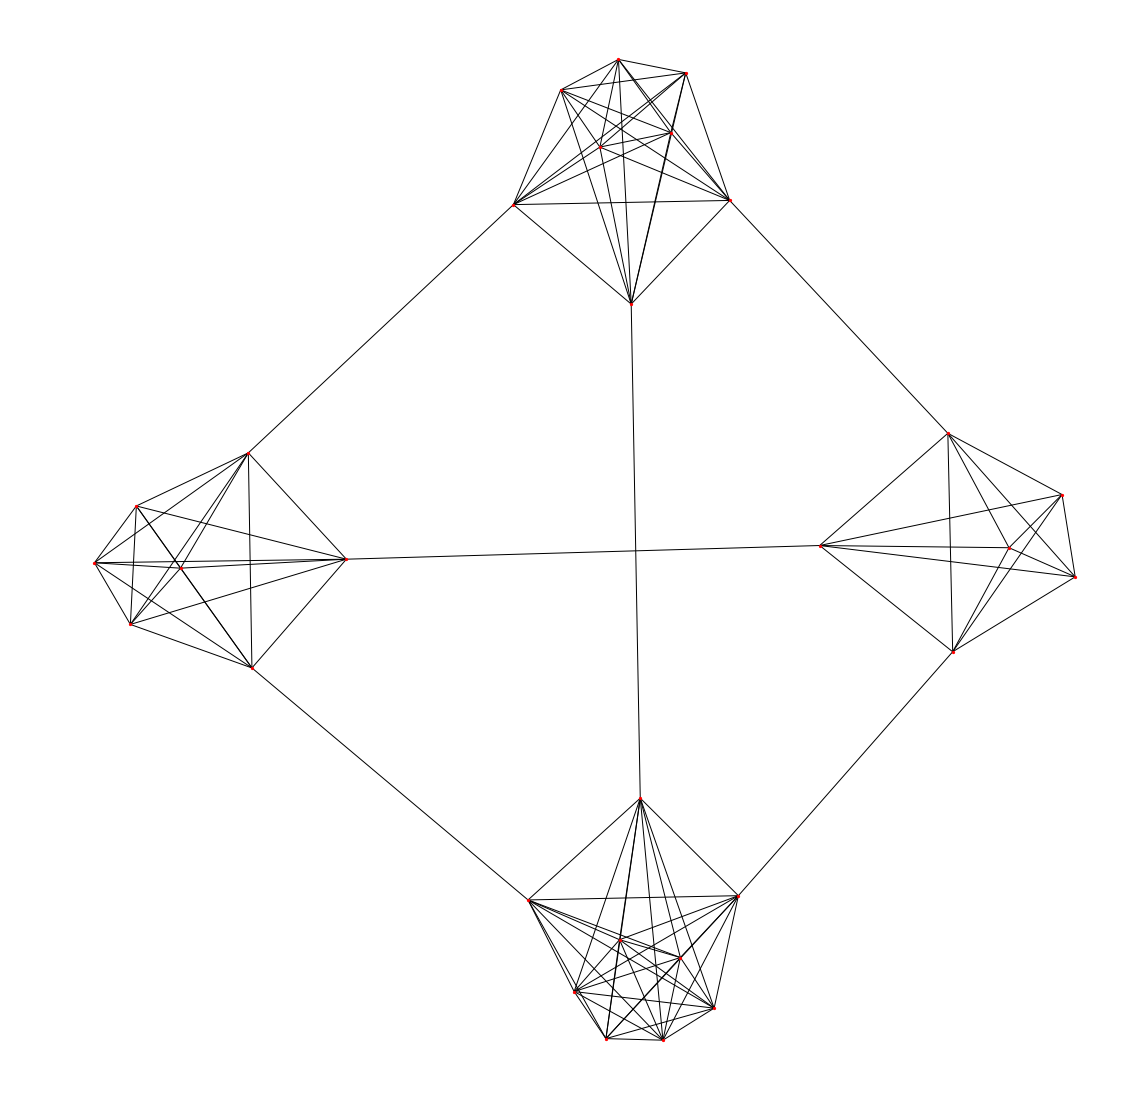

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15)) 
nx.draw_spring(graphs[0], node_size=5)
plt.show()

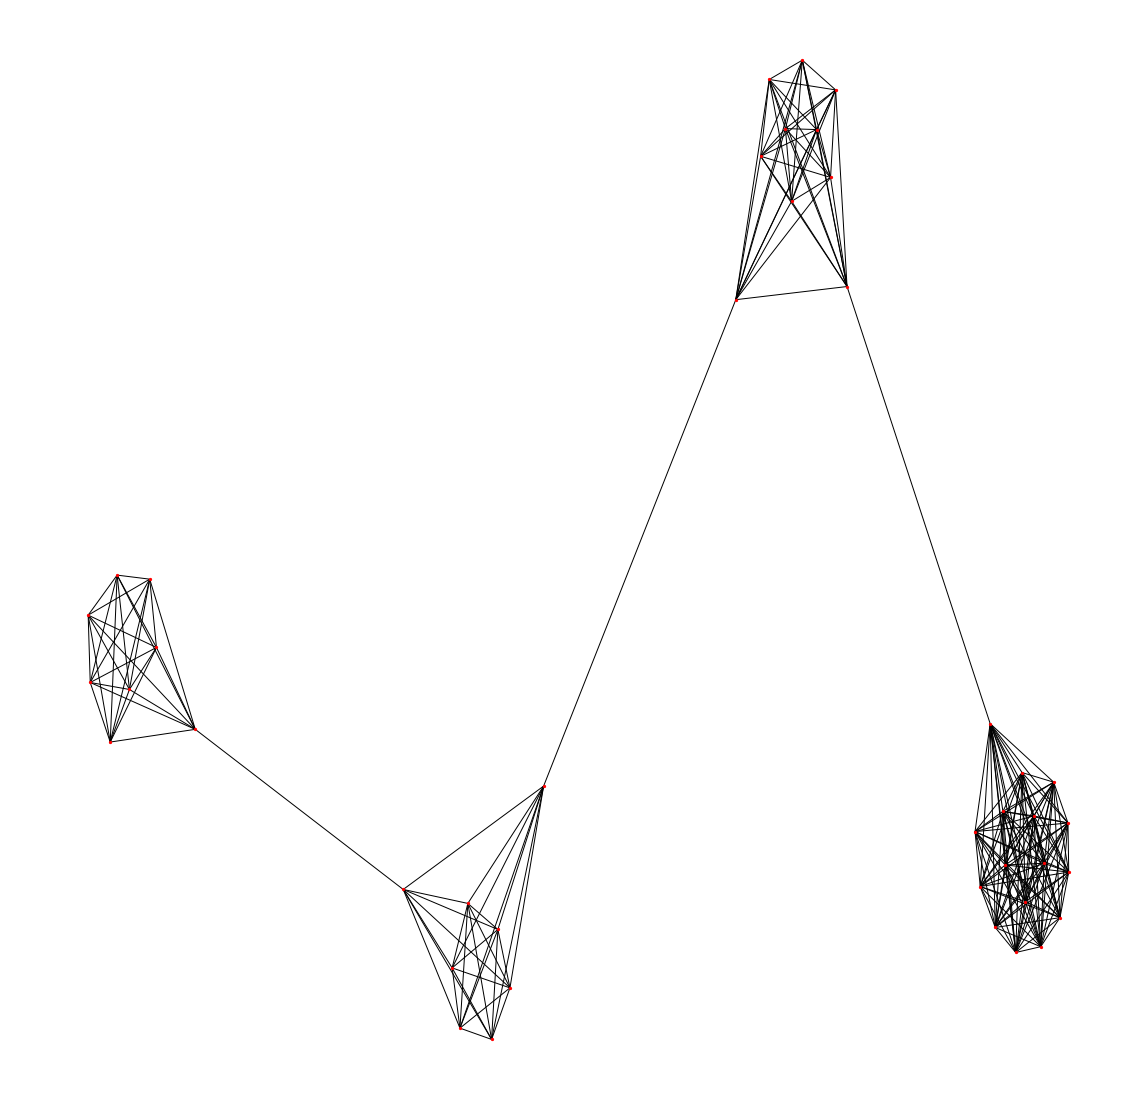

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15)) 
nx.draw_spring(graphs[1], node_size=5)
plt.show()

# Размеры

In [106]:
for i in range(len(graphs)):
    print("Размер графа {0} равен {1}".format(i, len(graphs[i])))

Размер графа 0 равен 30
Размер графа 1 равен 42


# Weiner index

Для вычисления этого индекса просто воспользуемся тем, что матрица смежности при возведении в степень становится матрицей расстояний равных степени (для элементов, которые до этого были равны 0)

In [12]:
gg=graphs[0]

In [13]:
def weiner_id(gg):
    adj_m=nx.to_numpy_matrix(gg)
    D=np.empty(adj_m.shape)
    D[:] = np.nan;
    np.fill_diagonal(D, 0)
    B = adj_m.copy()
    k = 1;
    while np.isnan(D).any():

        D[(B>0) & (np.isnan(D))] = k;

        k = k+1;
        B = B*adj_m;
    return D.sum()/2

## проверим корректность

In [14]:
weiner_id(gg)

1015.0

In [15]:
nx.wiener_index(gg)

1015.0

Все ок

In [16]:
res=[weiner_id(i) for i in graphs]

In [17]:
for i in range(len(res)):
    print("Для графа {0} индекс равен {1}".format(i , res[i]))

Для графа 0 индекс равен 1015.0
Для графа 1 индекс равен 2943.0


## Мера

Минимальный индекс равен $n(n-1)$ и достигается в полносвязном графе. Если минимум поделить на фактический индекс (индекс в конкретном графе, то получится % близости по структуре к полносвязному). В контексте террористов, это означает степень организованности. 100% будет означать, что все теракты организованны одной группой.

Возьмем модуль разности нормированных индексов:

In [18]:
print(abs((len(graphs[0])*(len(graphs[0])-1))/res[0]-(len(graphs[1])*(len(graphs[1])-1))/res[1]))

0.27202562982379497


**Вывод:** Теперь можно заявить, что с вероятностью 73% в 2001 и 2011 году действовали разные группировки.

# Hosoya index

Для вычисления этой величины воспользуемся тем, что наши графы состоят из клик и мостов между ними. Индекс Хосойи известен для полносвязных графов (телефонные номера). Задача вычисления индекса для наших графов сводится к задаче вычисления для полносвязных. 

Если мост оказался в паросочетании, то вершины которые он соединял можно удалить из графа и тогда размер клик которые он соединял просто уменьшиться на один (очевидно они останутся полносвязными). Если же мост не входит в паросочетание то просто удалим его как ребро. В итоге у нас останется n несвязанных клик. Индекс Хосойи для такого несвязанного графа будет просто равен произведению индексов для его клик (произведению телефонных номеров).

In [19]:
def split_by_max_cliques(gg):
    gc=gg.copy()
    mc=list(nx.find_cliques(gg))
    ccg=[]
    for i in mc:
        if len(i)>2:
            ccg.append(gg.subgraph(i))
    G=nx.Graph()
    for i in ccg:
        G=nx.compose(G,i)
    cgd=nx.difference(gg,G)
    edges = gg.edges()
    colors=[]
    bridges=[]
    for i in edges:
        if i in set(cgd.edges):
            colors.append("blue")
            bridges.append(i)
        else:
            colors.append("black")
    plt.figure(figsize=(15,15)) 
    nx.draw_spring(gg, edge_color=colors, node_size=5)
    plt.show()
    return bridges

In [20]:
def generate_components(i, G, res):
    if(i < len(res)):
        t=G.copy()
        t.remove_edges_from([res[i]])
        a=generate_components(i+1, t,res)
        t=G.copy()
        t.remove_nodes_from(res[i])
        b=generate_components(i+1, t,res)
        if a is None or b is None:
            return None
        return a+b
    else:
        l=list(nx.connected_component_subgraphs(G))
        for i in l:
            if not nx.is_connected(i):
                return None
        return [[len(i) for i in l]]
            

In [21]:
def generate_telephone_numbers(n):
    tn=[1, 1]
    for i in range(2, n+1):
        t=tn[i-1]+tn[i-2]*(i-1)
        tn.append(t)
    return tn

In [23]:
def calculate_hasoya_index(gc):
    res=split_by_max_cliques(gc)
    rr=generate_components(0, gc, res)
    tnl=generate_telephone_numbers(22)
    hi=0
    for i in rr:
        cmn=1
        for j in i:
            cmn*=tnl[j]
        hi+=cmn
    return hi

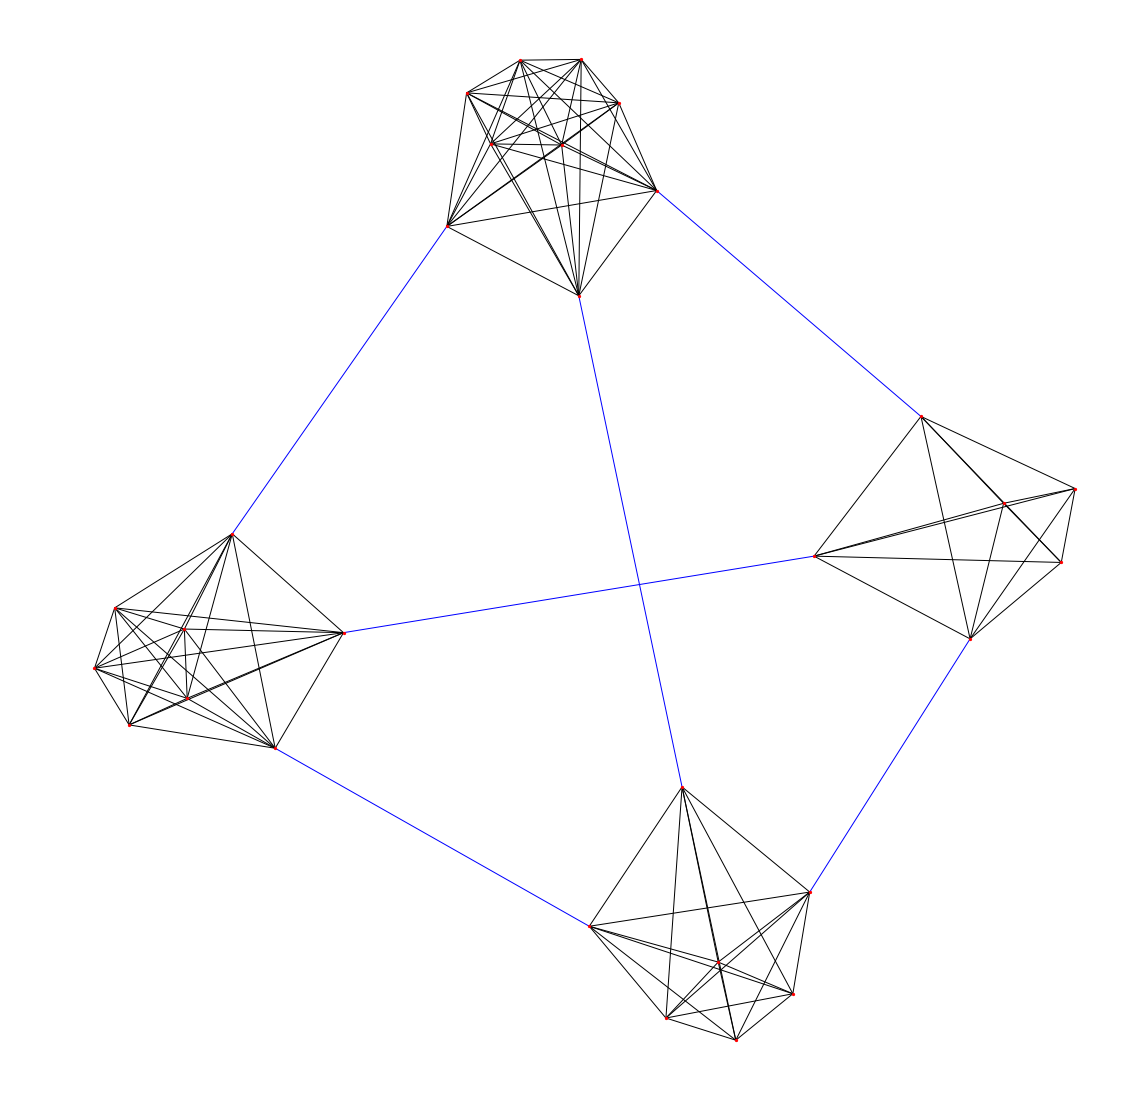

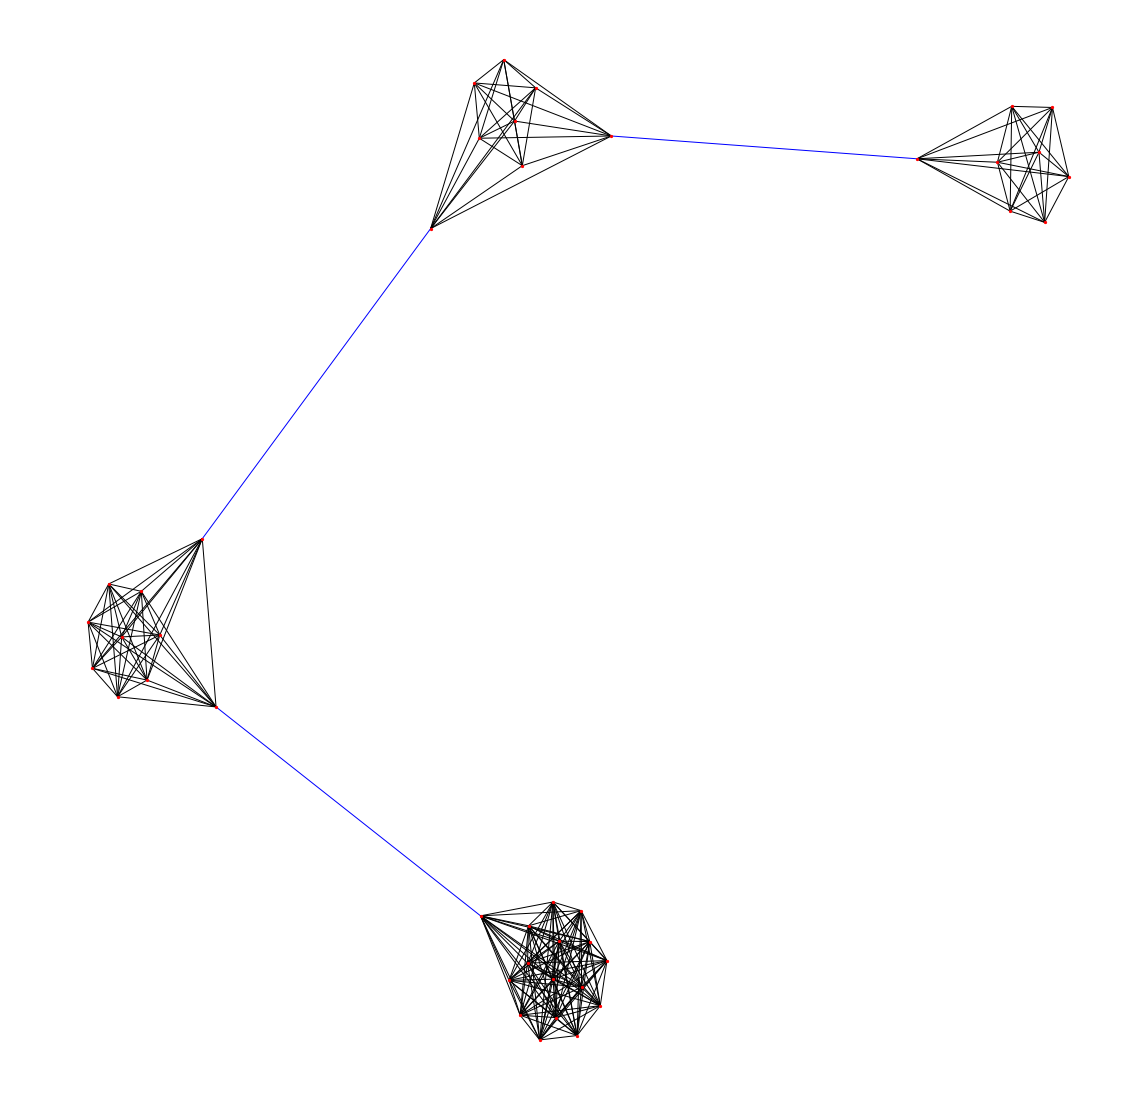

In [24]:
res=[]
for i in graphs:
    res.append(calculate_hasoya_index(i))

In [32]:
for i in range(len(res)):
    print("Для графа {0} индекс равен {1}".format(i , res[i]))

Для графа 0 индекс равен 62939731584
Для графа 1 индекс равен 322150767178608640


## Мера

Про индекс Хосойи нам известно, что он максимальный для полносвязного графа. Так воспользуемся этим!
Нормировка будет производиться по максимальному возможному число паросочетаний в графе размера k (где k - размер нормируемого графа). Расстояние в таком случае - модуль разности нормированных индексов Хосойи. Если граф похожи, то норма будет близка к 0. 

In [25]:
norm=generate_telephone_numbers(max(len(graphs[0]), len(graphs[1])))
for i in range(len(res)-1):
    print(abs(res[i]/norm[len(graphs[i])]-res[i+1]/norm[len(graphs[i+1])]))

1.0361140209579335e-07


**Вывод:** Индекс Хосойи наоборот утверждает, что графы похожи. Ничего удивительного, ведь много произшествий связаны между собой (одинаковое количество максимальных клик).

# Diameter, eccentricity, periphery, girth, expansion

In [95]:
def eccentricity(G):
    return {i : max(list(nx.single_source_shortest_path_length(G, i).values())) for i in G.nodes()}

def diameter(G):
    return max(eccentricity(G).values())

def periphery(G):
    e=eccentricity(G)
    d=diameter(G)
    return [i for i in G.nodes() if e[i]==d]


## eccentricity

Посмотрим средний_eccentricity. Это метрика будет опять же отражать степень связности событий в графе (в какой-то степени количество рукопожатий).

In [86]:
res=[]
for i in range(len(graphs)):
    e=eccentricity(graphs[i]).values()
    res.append(sum(e)/len(e))
    print("Для графа {0} средний eccentricity {1}".format(i , res[i]))

Для графа 0 средний eccentricity 3.0
Для графа 1 средний eccentricity 6.0476190476190474


Сразу можно сказать, что подтверждается теория 6 рукопожатий, а в графе 0 даже напоминает социальную сеть.

Для сравнения можно посмотреть разницу отношений 1 к среднему eccentricity:

In [87]:
print(abs(1/res[0]-1/res[1]))

0.16797900262467189


Разница 16%! Очевидно террористы в 2001 (в нашей переделке) слышали друг о друге.

## diameter

In [89]:
res=[]
for i in range(len(graphs)):
    res.append(diameter(graphs[i]))
    print("Для графа {0} диаметр равен {1}".format(i , res[i]))

Для графа 0 диаметр равен 3
Для графа 1 диаметр равен 7


Тут я бы нормировал средний eccentricity на диаметр и смотрел бы разность. Таким образом мы сможем сравнить вероятности наличие сети терроризма в конкретный год.

In [94]:
res=[]
for i in range(len(graphs)):
    e=eccentricity(graphs[i]).values()
    res.append(sum(e)/len(e))
print((res[0]/diameter(graphs[0])-res[1]/diameter(graphs[1])))

0.13605442176870752


Как было замечено раньше, в 2001 (в нашей версии) скорее всего существовал альянс террористов.

## periphery

Для periphery рассмотрим просто количество таких вершин:

In [97]:
res=[]
for i in range(len(graphs)):
    res.append(len(periphery(graphs[i])))
    print("Для графа {0} размер periphery равен {1}".format(i , res[i]))

Для графа 0 размер periphery равен 30
Для графа 1 размер periphery равен 22


Эти числа просто нормируем на количество вершин и посмотрим разность:

In [100]:
print(res[0]/len(graphs[0])- res[1]/len(graphs[1]))

0.47619047619047616


Такая большая разница говорит о том факте, что при сжатии графа по кликам (клика переводится в вершину) один из полученных графов будет вероятнее полносвязным. Переводя на "наш" язык, скорее всего в одном из годом действовала одна организация (даже известно в каком).

## girth

В нашем графе есть клики, а это значит, что минимальный размер цикла равен 3. Напишем дфс который подтвердит этот факт.

In [201]:
def dfs_find_cycles(n, G, p, res):
    for i in G.neighbors(n):
        if i in res and i != p: 
            return res
    for i in G.neighbors(n):
        if(i != p):
            res.add(i)
            r=dfs_find_cycles(i, G, n, res)
            if r:
                return r

In [202]:
def girth(G):
    for i in list(G.nodes()):
        n=i
        r=dfs_find_cycles(n, G, n, set())
        if(len(r)==3):
            return len(r)

In [203]:
res=[]
for i in graphs:
    res.append(girth(i))

In [205]:
for i in range(len(graphs)):
    print("Для графа {0} girth равен {1}".format(i, res[i]))

Для графа 0 girth равен 3
Для графа 1 girth равен 3


Сравнивать тут бесполезно. Girth только может сказать о наличие в графе клик (когда равно 3). Но в общем случае, это величину надо сравнивать с 3, что будет означать вероятность появления клики.

# Ядро

Внутренняя устойчивость - множество попарно несмежных вершин графа

Внешняя устойчивость - подмножество вершин графа, которое при объединении с соседями каждой входящей в него вершины, дает полное множество вершин графа

Воспользуемся простым фактом, что ядром клики является любая вершина (она же будет и максимальной). Что происходит когда мы соединяем клики мостами? Это лишает нас возможности взять одну комбинацию вершин из клик - вершины соединенные мостом, так как они будут не внутренне устойчивыми. Тогда нам остается просто найти клики, найти мосты и выбрать по вершине из клики, несоединенные мостами.

In [40]:
def get_kernel(gg):
    gc=gg.copy()
    mc=list(nx.find_cliques(gg))
    ccg=[]
    for i in mc:
        if len(i)>2:
            ccg.append(gg.subgraph(i))
    G=nx.Graph()
    for i in ccg:
        G=nx.compose(G,i)
    cgd=nx.difference(gg,G)
    edges = gg.edges()
    bridges=[]
    for i in edges:
        if i in set(cgd.edges):
            bridges.append(i)
    for i in bridges:
        G.remove_nodes_from(i)
    res = []
    for i in nx.connected_component_subgraphs(G):
        res.append(rc(list(i.nodes())))
    return res

In [66]:
def get_kernels_count(gg):
    gc=gg.copy()
    mc=list(nx.find_cliques(gg))
    ccg=[]
    for i in mc:
        if len(i)>2:
            ccg.append(gg.subgraph(i))
    G=nx.Graph()
    for i in ccg:
        G=nx.compose(G,i)
    cgd=nx.difference(gg,G)
    edges = gg.edges()
    bridges=[]
    for i in edges:
        if i in set(cgd.edges):
            bridges.append(i)
    G.remove_edges_from(bridges)
    res = 1
    for i in nx.connected_component_subgraphs(G):
        res *=  len(i)
    penalty = 0
    for i in bridges:
        tmp=G.copy()
        for j in nx.connected_component_subgraphs(G):
            if i[0] in set(j.nodes()) or i[1] in set(j.nodes()):
                tmp.remove_nodes_from(list(j.nodes))
        p=1
        for j in nx.connected_component_subgraphs(tmp):
            p *= len(j)
        penalty+=p
    return res-penalty

In [67]:
res = []
for i in graphs:
    res.append(get_kernel(i))

In [68]:
res

[[200108160009, 200110020003, 200112140002, 200108230001],
 [201111160074, 201111040018, 201112250024, 201110250031]]

Как видно количество мостов не влияент на размер ядер. Если бы граф имел бы более сложную структуру, то ядро могло бы что-то нам сказать, а так в данном случае это только указывает на количество клик.

Тогда просто сравним количество различных максимальных ядер.

In [69]:
res = []
for i in graphs:
    res.append(get_kernels_count(i))

In [71]:
for i in range(len(res)):
    print("Для графа {0} количество равно {1}".format(i , res[i]))

Для графа 0 количество равно 2689
Для графа 1 количество равно 9888


В качестве нормировки тогда можно рассматривать минимальное количество максимальных ядер (при полносвязном графе). Посчитаем модуль разности минимального количества максимальных ядер на количество ядер:

In [77]:
print(abs(len(graphs[0])/res[0]- len(graphs[1])/res[1]))

0.006908990962822286


Как ни странно разница близка к 1%, но этого уже достаточно чтобы подозревать наличие разницы в структуре (в нашем случае это количество мостов).

# Edit distance

In [361]:
from __future__ import print_function
import math
import networkx as nx
from operator import *
import sys


def debug_print(*args, **kwargs):
    print(*args, **kwargs)


def graph_edit_distance(G1, G2):
    bestcost = None
    for vertex_path, edge_path, cost in \
            optimize_edit_paths(G1, G2):
        # assert bestcost is None or cost < bestcost
        bestcost = cost
    return bestcost



def optimize_edit_paths(G1, G2):

    import numpy as np
    from scipy.optimize import linear_sum_assignment

    class CostMatrix:
        def __init__(self, C, lsa_row_ind, lsa_col_ind, ls):
            self.C = C
            self.lsa_row_ind = lsa_row_ind
            self.lsa_col_ind = lsa_col_ind
            self.ls = ls

    def make_CostMatrix(C, m, n):
        # assert(C.shape == (m + n, m + n))
        lsa_row_ind, lsa_col_ind = linear_sum_assignment(C)

        # Fixup dummy assignments:
        # each substitution i<->j should have dummy assignment m+j<->n+i
        # NOTE: fast reduce of Cv relies on it
        # assert len(lsa_row_ind) == len(lsa_col_ind)
        indexes = zip(range(len(lsa_row_ind)), lsa_row_ind, lsa_col_ind)
        subst_ind = list(k for k, i, j in indexes if i < m and j < n)
        indexes = zip(range(len(lsa_row_ind)), lsa_row_ind, lsa_col_ind)
        dummy_ind = list(k for k, i, j in indexes if i >= m and j >= n)
        # assert len(subst_ind) == len(dummy_ind)
        lsa_row_ind[dummy_ind] = lsa_col_ind[subst_ind] + m
        lsa_col_ind[dummy_ind] = lsa_row_ind[subst_ind] + n

        return CostMatrix(C, lsa_row_ind, lsa_col_ind,
                          C[lsa_row_ind, lsa_col_ind].sum())

    def extract_C(C, i, j, m, n):
        # assert(C.shape == (m + n, m + n))
        row_ind = [k in i or k - m in j for k in range(m + n)]
        col_ind = [k in j or k - n in i for k in range(m + n)]
        return C[row_ind, :][:, col_ind]

    def reduce_C(C, i, j, m, n):
        # assert(C.shape == (m + n, m + n))
        row_ind = [k not in i and k - m not in j for k in range(m + n)]
        col_ind = [k not in j and k - n not in i for k in range(m + n)]
        return C[row_ind, :][:, col_ind]

    def reduce_ind(ind, i):
        # assert set(ind) == set(range(len(ind)))
        rind = ind[[k not in i for k in ind]]
        for k in set(i):
            rind[rind >= k] -= 1
        return rind

    def match_edges(u, v, pending_g, pending_h, Ce, matched_uv=[]):

        M = len(pending_g)
        N = len(pending_h)
        # assert Ce.C.shape == (M + N, M + N)

        g_ind = [i for i in range(M) if pending_g[i][:2] == (u, u) or
                 any(pending_g[i][:2] in ((p, u), (u, p))
                     for p, q in matched_uv)]
        h_ind = [j for j in range(N) if pending_h[j][:2] == (v, v) or
                 any(pending_h[j][:2] in ((q, v), (v, q))
                     for p, q in matched_uv)]
        m = len(g_ind)
        n = len(h_ind)

        if m or n:
            C = extract_C(Ce.C, g_ind, h_ind, M, N)
            # assert C.shape == (m + n, m + n)

            # Forbid structurally invalid matches
            # NOTE: inf remembered from Ce construction
            for k, i in zip(range(m), g_ind):
                g = pending_g[i][:2]
                for l, j in zip(range(n), h_ind):
                    h = pending_h[j][:2]
                    if nx.is_directed(G1) or nx.is_directed(G2):
                        if any(g == (p, u) and h == (q, v) or
                               g == (u, p) and h == (v, q)
                               for p, q in matched_uv):
                            continue
                    else:
                        if any(g in ((p, u), (u, p)) and h in ((q, v), (v, q))
                               for p, q in matched_uv):
                            continue
                    if g == (u, u):
                        continue
                    if h == (v, v):
                        continue
                    C[k, l] = inf

            localCe = make_CostMatrix(C, m, n)
            ij = list((g_ind[k] if k < m else M + h_ind[l],
                       h_ind[l] if l < n else N + g_ind[k])
                      for k, l in zip(localCe.lsa_row_ind, localCe.lsa_col_ind)
                      if k < m or l < n)

        else:
            ij = []
            localCe = CostMatrix(np.empty((0, 0)), [], [], 0)

        return ij, localCe

    def reduce_Ce(Ce, ij, m, n):
        if len(ij):
            i, j = zip(*ij)
            m_i = m - sum(1 for t in i if t < m)
            n_j = n - sum(1 for t in j if t < n)
            return make_CostMatrix(reduce_C(Ce.C, i, j, m, n), m_i, n_j)
        else:
            return Ce

    def get_edit_ops(matched_uv, pending_u, pending_v, Cv,
                     pending_g, pending_h, Ce, matched_cost):

        m = len(pending_u)
        n = len(pending_v)

        # 1) a vertex mapping from optimal linear sum assignment
        i, j = min((k, l) for k, l in zip(Cv.lsa_row_ind, Cv.lsa_col_ind)
                   if k < m or l < n)
        xy, localCe = match_edges(pending_u[i] if i < m else None,
                                  pending_v[j] if j < n else None,
                                  pending_g, pending_h, Ce, matched_uv)
        Ce_xy = reduce_Ce(Ce, xy, len(pending_g), len(pending_h))
        # assert Ce.ls <= localCe.ls + Ce_xy.ls
        if prune(matched_cost + Cv.ls + localCe.ls + Ce_xy.ls):
            pass
        else:
            # get reduced Cv efficiently
            Cv_ij = CostMatrix(reduce_C(Cv.C, (i,), (j,), m, n),
                               reduce_ind(Cv.lsa_row_ind, (i, m + j)),
                               reduce_ind(Cv.lsa_col_ind, (j, n + i)),
                               Cv.ls - Cv.C[i, j])
            yield (i, j), Cv_ij, xy, Ce_xy, Cv.C[i, j] + localCe.ls

        # 2) other candidates, sorted by lower-bound cost estimate
        other = list()
        fixed_i, fixed_j = i, j
        if m <= n:
            candidates = ((t, fixed_j) for t in range(m + n)
                          if t != fixed_i and (t < m or t == m + fixed_j))
        else:
            candidates = ((fixed_i, t) for t in range(m + n)
                          if t != fixed_j and (t < n or t == n + fixed_i))
        for i, j in candidates:
            if prune(matched_cost + Cv.C[i, j] + Ce.ls):
                continue
            Cv_ij = make_CostMatrix(reduce_C(Cv.C, (i,), (j,), m, n),
                                    m - 1 if i < m else m,
                                    n - 1 if j < n else n)
            if prune(matched_cost + Cv.C[i, j] + Cv_ij.ls + Ce.ls):
                continue
            xy, localCe = match_edges(pending_u[i] if i < m else None,
                                      pending_v[j] if j < n else None,
                                      pending_g, pending_h, Ce, matched_uv)
            if prune(matched_cost + Cv.C[i, j] + Cv_ij.ls + localCe.ls):
                continue
            Ce_xy = reduce_Ce(Ce, xy, len(pending_g), len(pending_h))
            if prune(matched_cost + Cv.C[i, j] + Cv_ij.ls + localCe.ls +
                     Ce_xy.ls):
                continue
            other.append(((i, j), Cv_ij, xy, Ce_xy, Cv.C[i, j] + localCe.ls))

        # yield from
        for t in sorted(other, key=lambda t: t[4] + t[1].ls + t[3].ls):
            yield t

    def get_edit_paths(matched_uv, pending_u, pending_v, Cv,
                       matched_gh, pending_g, pending_h, Ce, matched_cost):


        if prune(matched_cost + Cv.ls + Ce.ls):
            return

        if not max(len(pending_u), len(pending_v)):
            maxcost.value = min(maxcost.value, matched_cost)
            yield matched_uv, matched_gh, matched_cost

        else:
            edit_ops = get_edit_ops(matched_uv, pending_u, pending_v, Cv,
                                    pending_g, pending_h, Ce, matched_cost)
            for ij, Cv_ij, xy, Ce_xy, edit_cost in edit_ops:
                i, j = ij
                if prune(matched_cost + edit_cost + Cv_ij.ls + Ce_xy.ls):
                    continue

                # dive deeper
                u = pending_u.pop(i) if i < len(pending_u) else None
                v = pending_v.pop(j) if j < len(pending_v) else None
                matched_uv.append((u, v))
                for x, y in xy:
                    len_g = len(pending_g)
                    len_h = len(pending_h)
                    matched_gh.append((pending_g[x] if x < len_g else None,
                                       pending_h[y] if y < len_h else None))
                sortedx = list(sorted(x for x, y in xy))
                sortedy = list(sorted(y for x, y in xy))
                G = list((pending_g.pop(x) if x < len(pending_g) else None)
                         for x in reversed(sortedx))
                H = list((pending_h.pop(y) if y < len(pending_h) else None)
                         for y in reversed(sortedy))

                # yield from
                for t in get_edit_paths(matched_uv, pending_u, pending_v,
                                        Cv_ij,
                                        matched_gh, pending_g, pending_h,
                                        Ce_xy,
                                        matched_cost + edit_cost):
                    yield t

                # backtrack
                if u is not None:
                    pending_u.insert(i, u)
                if v is not None:
                    pending_v.insert(j, v)
                matched_uv.pop()
                for x, g in zip(sortedx, reversed(G)):
                    if g is not None:
                        pending_g.insert(x, g)
                for y, h in zip(sortedy, reversed(H)):
                    if h is not None:
                        pending_h.insert(y, h)
                for t in xy:
                    matched_gh.pop()

    # Initialization

    pending_u = list(G1.nodes)
    pending_v = list(G2.nodes)

    # cost matrix of vertex mappings
    m = len(pending_u)
    n = len(pending_v)
    C = np.zeros((m + n, m + n))



    del_costs = [1] * len(pending_u)


    ins_costs = [1] * len(pending_v)

    inf = C[0:m, 0:n].sum() + sum(del_costs) + sum(ins_costs) + 1
    C[0:m, n:n + m] = np.array([del_costs[i] if i == j else inf
                                for i in range(m) for j in range(m)]
                               ).reshape(m, m)
    C[m:m + n, 0:n] = np.array([ins_costs[i] if i == j else inf
                                for i in range(n) for j in range(n)]
                               ).reshape(n, n)
    Cv = make_CostMatrix(C, m, n)


    pending_g = list(G1.edges)
    pending_h = list(G2.edges)

    # cost matrix of edge mappings
    m = len(pending_g)
    n = len(pending_h)
    C = np.zeros((m + n, m + n))


    del_costs = [1] * len(pending_g)

    ins_costs = [1] * len(pending_h)
    inf = C[0:m, 0:n].sum() + sum(del_costs) + sum(ins_costs) + 1
    C[0:m, n:n + m] = np.array([del_costs[i] if i == j else inf
                                for i in range(m) for j in range(m)]
                               ).reshape(m, m)
    C[m:m + n, 0:n] = np.array([ins_costs[i] if i == j else inf
                                for i in range(n) for j in range(n)]
                               ).reshape(n, n)
    Ce = make_CostMatrix(C, m, n)


    class MaxCost:
        def __init__(self):
            self.value = Cv.C.sum() + Ce.C.sum() + 1

    maxcost = MaxCost()

    def prune(cost):
        if cost >= maxcost.value:
            return True

    # Now go!

    for vertex_path, edge_path, cost in \
            get_edit_paths([], pending_u, pending_v, Cv,
                           [], pending_g, pending_h, Ce, 0):
        yield list(vertex_path), list(edge_path), cost

In [362]:
g1=nx.complete_graph(5)
g2=nx.complete_graph(3)

In [363]:
graph_edit_distance(g1, g2)

9.0